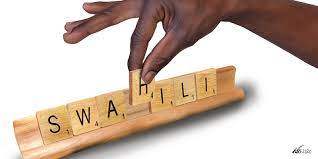
## EAST AFRICA VIRTUAL HACKATHON 2021: SWAHILI NEWS ML CHALLENGE 

### <font color = blue /> Objective of the above Hackathon:

**The objective of this hackathon is to develop a multi-class classification model to classify news content according to six specific categories.The model can be used by Swahili online platforms to automatically group news according to their categories and help readers find the specific news they want to read. In addition, the model will contribute to a body of work ensuring that Swahili is represented in apps and other online products in future.**

In [1]:
# import important modules
import numpy as np
import pandas as pd
import spacy
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer


# sklearn modules
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB # classifier 

from sklearn.metrics import log_loss #evaluation metric
from sklearn.feature_extraction.text import CountVectorizer

# text preprocessing modules
import re 
from string import punctuation 

import warnings
warnings.filterwarnings("ignore")
# seeding
np.random.seed(123)


In [25]:
# load data
path = ''
train = pd.read_csv(path+"train.csv")
test = pd.read_csv(path+"test.csv")
submission = pd.read_csv(path+"sample_submission.csv")

In [26]:
stopword=["akasema","alikuwa"," alisema","baada","basi","bila","cha","chini","hadi","hapo","hata","hivyo","hiyo","huku","huo","ili","ilikuwa","juu","kama","karibu","katika","kila","kima","kisha","kubwa","kutoka","kuwa","kwa","kwamba","kwenda","kwenye ","la","lakini","mara","mdogo","mimi","mkubwa","mmoja","moja","muda","mwenye","na","naye","ndani","ng","ni","nini","nonkungu","pamoja","pia","sana","sasa","sauti","tafadhali","tena","tu","vile","wa","wakati","wake","walikuwa","wao","watu","wengine","wote","ya","yake","yangu","yao","yeye","yule ","za","zaidi","zake"]


In [27]:
# show top five rows of train data
train.head() 

,id,content,category
0,SW4670,"Bodi ya Utalii Tanzania (TTB) imesema, itafan...",uchumi
1,SW30826,"PENDO FUNDISHA-MBEYA RAIS Dk. John Magufuri, ...",kitaifa
2,SW29725,Mwandishi Wetu -Singida BENKI ya NMB imetoa ms...,uchumi
3,SW20901,"TIMU ya taifa ya Tanzania, Serengeti Boys jan...",michezo
4,SW12560,Na AGATHA CHARLES – DAR ES SALAAM ALIYEKUWA K...,kitaifa


In [28]:
# show top five rows of test data
test.head()

,id,content
0,SW4255,WAZIRI MKUU Kassim Majaliwa amep okea leseni ...
1,SW15677,RAIS John Magufuli amewataka viongozi wa Halm...
2,SW15925,"NEW YORK, MAREKANI MKALI wa hip hop nchini Mar..."
3,SW7615,"WAZIRI wa Kilimo, Dk Charles Tizeba amelitaka..."
4,SW28011,"Mwandishi wetu, Tanga WAFANYABIASHARA wa Mkoa ..."


In [29]:
# show top five rows of submision file
submission.head()

,test_id,kitaifa,michezo,burudani,uchumi,kimataifa,afya
0,SW4255,1.0,0.0,0.0,0.0,0.0,0.0
1,SW15677,0.0,0.0,0.0,1.0,0.0,0.0
2,SW15925,NaN,NaN,NaN,NaN,NaN,NaN
3,SW7615,NaN,NaN,NaN,NaN,NaN,NaN
4,SW28011,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
# check the shape of the train data
train.shape

(23268, 3)

In [31]:
# check the shape of the test data
test.shape

(7756, 2)

In [32]:
# check missing values in train data
train.isnull().sum()

id          0
content     0
category    0
dtype: int64

In [33]:
# check missing values in test data
test.isnull().sum()

id         0
content    0
dtype: int64

In [34]:
# evalute news category distribution
train.category.value_counts()

kitaifa      10242
michezo       6004
burudani      2229
uchumi        2028
kimataifa     1906
afya           859
Name: category, dtype: int64

### Data Preparation 

In [35]:
# a mapping dictionary that maps the category values from 0 to 5
category_mapping = {
"kitaifa": 0,
"michezo": 1,
"burudani": 2,
"uchumi": 3,
"kimataifa": 4,
"afya": 5
}

train["category"] = train.category.map(category_mapping)

train.head()

,id,content,category
0,SW4670,"Bodi ya Utalii Tanzania (TTB) imesema, itafan...",3
1,SW30826,"PENDO FUNDISHA-MBEYA RAIS Dk. John Magufuri, ...",0
2,SW29725,Mwandishi Wetu -Singida BENKI ya NMB imetoa ms...,3
3,SW20901,"TIMU ya taifa ya Tanzania, Serengeti Boys jan...",1
4,SW12560,Na AGATHA CHARLES – DAR ES SALAAM ALIYEKUWA K...,0


In [36]:
# a simple function to clean text data 
#ps = nltk.PorterStemmer()
#from nltk.tokenize import word_tokenize
def text_cleaning(text):
    
    # Clean the text data
    text = re.sub(r"[^A-Za-z0-9]", " ", text) # remove punctuation marks
    text = re.sub(r'\b\d+(?:\.\d+)?\s+', '', text) # remove numbers
    text = re.sub(r'\^[a-zA-Z]\s+', ' ', text)# remove single character in a sentence.
    text = re.sub(r'\s+', ' ', text, flags=re.I) # Removing double spaces in the documents.
    text = text.lower()  # set in lowercase 
    text = re.sub(r'^b\s+', '', text) # remove the prefix
    text =  [c for c in text if c not in stopword]  # removing all the stopwords in the sentences
    # Remove punctuation from text
    text = ''.join([c for c in text if c not in punctuation])
    #text = [ps.stem(text) for text in text] # Stemming in its the original form
    return(text)

In [37]:
#clean the train and test data
train["content"] = train["content"].apply(text_cleaning)
test["content"] = test["content"].apply(text_cleaning)

In [38]:
#split features and target from train data 
X = train["content"]
y = train.category.values

In [39]:
# Transform text data 
vectorizer = CountVectorizer(lowercase=False)

vectorizer.fit(X)

#transform train data 
X_transformed = vectorizer.transform(X)

#transform test data
test_transformed = vectorizer.transform(test["content"])

In [40]:
# split data into train and validate

X_train, X_valid, y_train, y_valid = train_test_split(
    X_transformed,
    y,
    test_size=0.20,
    random_state=46,
    shuffle=True,
    stratify=y,
)

### Create Classifier 

In [41]:
# Create a classifier
from sklearn.linear_model import LogisticRegression
news_classifier = LogisticRegression()   

In [42]:
# train the news_classifier 
news_classifier.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [43]:
# test model performance on valid data 
y_probas = news_classifier.predict_proba(X_valid)

In [44]:
# evalute model performance by using log_loss in the validation data
log_loss(y_valid, y_probas)

0.5920229274818859

In [45]:
# create prediction from the test data
test_probas = news_classifier.predict_proba(test_transformed)

### Create Submission File

In [ ]:
# create submission file 
submission_cols = ['kitaifa', 'michezo', 'burudani','uchumi', 'kimataifa', 'afya'] 
submission_df = pd.DataFrame(test_probas, columns = submission_cols)
submission_df['test_id'] = submission['test_id']   # add  test_id 

#rearange columns 
submission_df = submission_df[['test_id','kitaifa', 'michezo', 'burudani','uchumi', 'kimataifa', 'afya']]

# save submission file 
submission_df.to_csv(path+"first_submission.csv",index=False) 

Trying another model to evaluate:

In [ ]:
news_classifier = MultinomialNB()  

In [ ]:
news_classifier.fit(X_train,y_train)

In [ ]:
y_probas_2 = news_classifier.predict_proba(X_valid)

In [ ]:
# evalute model performance by using log_loss in the validation data
log_loss(y_valid, y_probas_2)

In [ ]:
# create prediction from the test data
test_probas = news_classifier.predict_proba(test_transformed)

In [ ]:
# create submission file 
submission_cols = ['kitaifa', 'michezo', 'burudani','uchumi', 'kimataifa', 'afya'] 
submission_df = pd.DataFrame(test_probas, columns = submission_cols)
submission_df['test_id'] = submission['test_id']   # add  test_id 

#rearange columns 
submission_df = submission_df[['test_id','kitaifa', 'michezo', 'burudani','uchumi', 'kimataifa', 'afya']]

# save submission file 
submission_df.to_csv(path+"submission_model2.csv",index=False) 